In [1]:
from scipy.io import loadmat

In [2]:
import numpy as np
from scipy.linalg import expm, logm

In [3]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

In [406]:
plt.style.use('seaborn-white')

In [4]:
data_odor = loadmat('/Users/linggeli/neuroscience/data/SuperChris/super_chris_extraction_odor2s.mat')

In [147]:
trial_info = data_odor['trialInfo']
select_odor = (trial_info[:, 0] == 1) & (trial_info[:, 1] == 1) & (trial_info[:, 3] < 5)

In [148]:
lfp_data = data_odor['lfpEpoch'][select_odor, 2000:4000, 5:15]

In [149]:
print(lfp_data.shape)

(168, 2000, 10)


In [260]:
cov_series = np.zeros((150, 100, 10, 10))  # time series of covariance matrices
utv_series = np.zeros((150, 100, 55))  # time series of upper triangular vector
for i in range(150):
    for t in range(100):
        lfp_window = lfp_data[i, (t * 10):(t * 10 + 50), :]
        cov = np.cov(lfp_window, rowvar=False)
        cov_series[i, t, :, :] = cov
        utv = logm(cov)[np.triu_indices(10)]
        utv_series[i, t, :] = utv

In [261]:
X = utv_series.reshape((15000, 55))
print(X.shape)

(15000, 55)


In [262]:
X_scale = (X - np.mean(X)) / np.std(X)

In [263]:
indices = np.random.permutation(15000)
X_train = X_scale[indices[:10000]]
X_val = X_scale[indices[10000:]]

In [264]:
print(X_train.shape)
print(X_val.shape)

(10000, 55)
(5000, 55)


In [265]:
from sklearn.decomposition import PCA

In [267]:
latent_dim = 5

In [268]:
pca = PCA(n_components=latent_dim)
components = pca.fit_transform(X_train)

In [269]:
X_hat = pca.inverse_transform(components)
mse = np.mean((X_train - X_hat) ** 2)
print(mse)

0.010704108456221065


In [270]:
components = pca.transform(X_val)
X_hat = pca.inverse_transform(components)
mse = np.mean((X_val - X_hat) ** 2)
print(mse)

0.01076329499914927


In [298]:
components = pca.transform(X_scale[:100])
print(components.shape)

(100, 5)


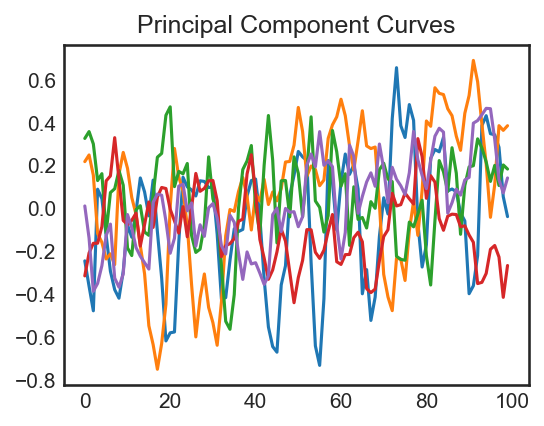

In [410]:
fig = plt.figure(figsize=(4, 3), dpi=150)
for j in range(5):
    plt.plot(components[:, j])
plt.title('Principal Component Curves')
plt.show()

In [411]:
from keras.models import Sequential
from keras.layers import Dense, Input, Lambda

In [412]:
model = Sequential()
model.add(Dense(20, input_dim=55, activation='relu'))
model.add(Dense(5, activation='linear'))
model.add(Dense(20, activation='relu'))
model.add(Dense(55, activation='linear'))

In [413]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_117 (Dense)            (None, 20)                1120      
_________________________________________________________________
dense_118 (Dense)            (None, 5)                 105       
_________________________________________________________________
dense_119 (Dense)            (None, 20)                120       
_________________________________________________________________
dense_120 (Dense)            (None, 55)                1155      
Total params: 2,500
Trainable params: 2,500
Non-trainable params: 0
_________________________________________________________________


In [414]:
model.compile(optimizer='adam', loss='mse')

In [415]:
history = model.fit(X_train, X_train, batch_size=100, epochs=100, verbose=0, validation_data=(X_val, X_val))

In [417]:
train_loss = history.history['loss']
valid_loss = history.history['val_loss']

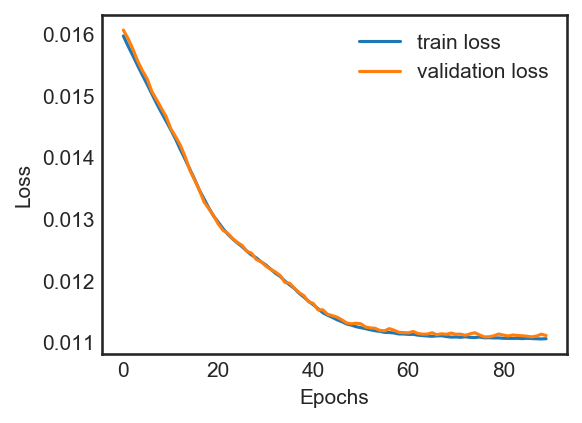

In [418]:
fig = plt.figure(figsize=(4, 3), dpi=150)
plt.plot(train_loss[10:], label="train loss")
plt.plot(valid_loss[10:], label="validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [307]:
from keras import backend as K

# with a Sequential model
get_3rd_layer_output = K.function([model.layers[0].input],
                                  [model.layers[1].output])

layer_output = get_3rd_layer_output([X_scale[:100]])[0]

In [308]:
print(layer_output.shape)

(100, 5)


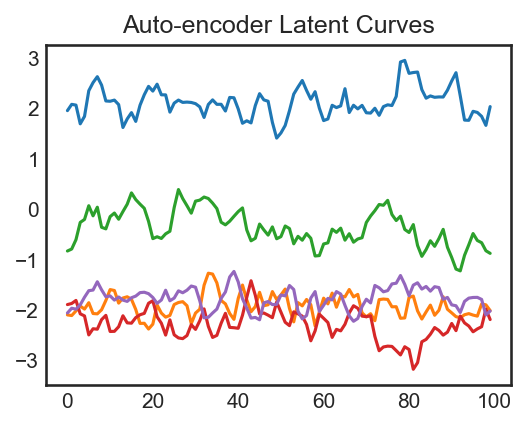

In [409]:
fig = plt.figure(figsize=(4, 3), dpi=150)
for j in range(5):
    plt.plot(layer_output[:, j])
plt.title('Auto-encoder Latent Curves')
plt.show()

In [376]:
original_dim = 55
intermediate_dim = 10
batch_size = 100
latent_dim = 5
epochs = 50

In [377]:
x = Input(batch_shape=(batch_size, original_dim))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_sigma = Dense(latent_dim)(h)

In [378]:
from keras.models import Model

In [379]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim))
    return z_mean + K.exp(z_log_sigma) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
# so you could write `Lambda(sampling)([z_mean, z_log_sigma])`
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])

In [380]:
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

In [381]:
# end-to-end autoencoder
vae = Model(x, x_decoded_mean)

# encoder, from inputs to latent space
encoder = Model(x, z_mean)

# generator, from latent space to reconstructed inputs
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

In [382]:
from keras.losses import mse, binary_crossentropy

In [383]:
def vae_loss(x, x_decoded_mean):
    xent_loss = binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return xent_loss + kl_loss

vae.compile(optimizer='adam', loss=vae_loss, metrics=['mse'])

In [396]:
vae.fit(X_train, X_train, epochs=10, batch_size=batch_size, validation_data=(X_val, X_val))

Train on 10000 samples, validate on 5000 samples
Epoch 1/10
10000/10000 [==============================] - 0s 47us/step - loss: -5.4043 - mean_squared_error: 0.7944 - val_loss: -5.4104 - val_mean_squared_error: 0.7945
Epoch 2/10
10000/10000 [==============================] - 0s 47us/step - loss: -5.4187 - mean_squared_error: 0.7944 - val_loss: -5.4207 - val_mean_squared_error: 0.7945
Epoch 3/10
10000/10000 [==============================] - 0s 44us/step - loss: -5.4287 - mean_squared_error: 0.7944 - val_loss: -5.4381 - val_mean_squared_error: 0.7944
Epoch 4/10
10000/10000 [==============================] - 1s 53us/step - loss: -5.4411 - mean_squared_error: 0.7944 - val_loss: -5.4483 - val_mean_squared_error: 0.7945
Epoch 5/10
10000/10000 [==============================] - 1s 61us/step - loss: -5.4551 - mean_squared_error: 0.7944 - val_loss: -5.4621 - val_mean_squared_error: 0.7945
Epoch 6/10
10000/10000 [==============================] - 0s 48us/step - loss: -5.4677 - mean_squared_erro

In [397]:
latent = encoder.predict(X_scale[:100])

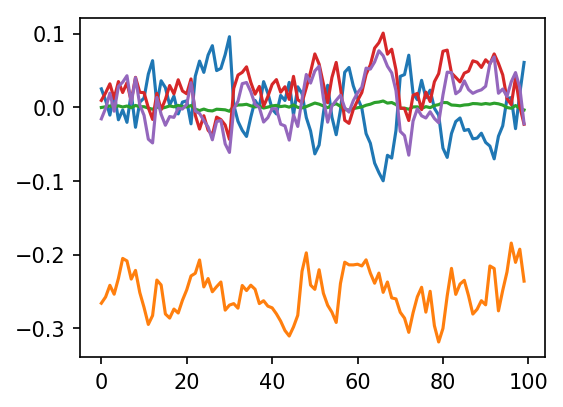

In [398]:
fig = plt.figure(figsize=(4, 3), dpi=150)
for j in range(5):
    plt.plot(latent[:, j])
plt.show()

In [399]:
latent = encoder.predict(X_train)

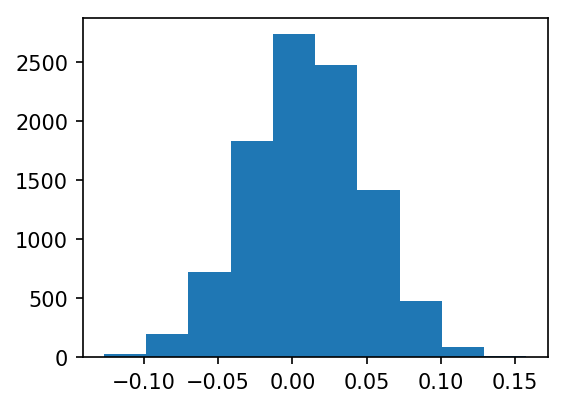

In [403]:
fig = plt.figure(figsize=(4, 3), dpi=150)
plt.hist(latent[:, 0])
plt.show()

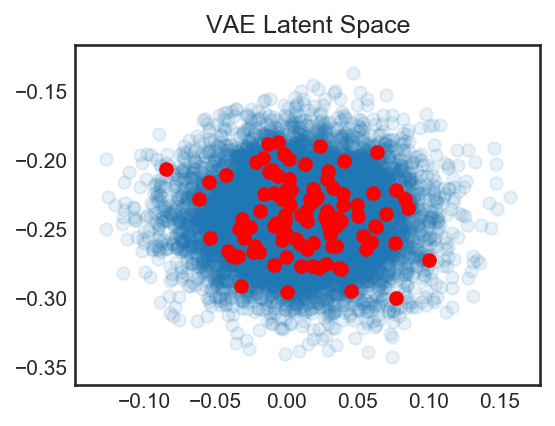

In [407]:
fig = plt.figure(figsize=(4, 3), dpi=150)
plt.scatter(latent[:, 0], latent[:, 1], alpha=0.1)
plt.scatter(latent[:100, 0], latent[:100, 1], color='red')
plt.title('VAE Latent Space')
plt.show()